# Лабораторная работа №1 «Численное решение дифференциальных уравнений»



## Вступление

В первой лабораторной Вашей задачей будет изучить и реализовать различные методы для численного решения дифференциальных уравнений.

Наверное, из курса физики Вы успели заметить, что дифференциальные уравнения появляются при описании явлений современного мира практически повсеместно, и практически никогда эти уравнения невозможно разрешить даже в квадратурах (выразив $y(x)$ через элементарные функции и интегралы от них).

Однако, физическими задачами уже никого не удивить, а уравнение движения маятника Вам уже, наверное, набило оскомину. Да и складывающееся ощущение, что дифференциальные уравнения возникают только лишь в задачах естествознания, ошибочно. Чтобы показать это, в качестве задачи в данной лабораторной работе рассматривается интересный пример использования дифференциальных уравнений в задачах искусственного интеллекта. *Неожиданно?!* Давайте разбираться.

## Задание 1. Численное решение дифференциального уравнения первого порядка.

Прежде чем приступить к интеллекту искусственному, применим интеллект естественный для реализации функций численного решения дифференциальных уравнений.


### Описание задачи

Так как дальше нам понадобится решать систему уравнений, то сразу будем решать задачу Коши
$$
\begin{cases} x(t)' = f(t, x(t)),\\ x(t_0) = x_0 \end{cases} \quad \text{где } x,x_0 \in \mathbb{R}^n, \ t \in [t_0,T].
$$

Рассмотрим два, наверное, самых распространенных метода:
- Метод ломаных Эйлера,
- Метод Рунге—Кутты.

Импортируем необходимые нам далее библиотеки.

In [9338]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Метод ломаных Эйлера

Метод Эйлера — это канонический и, честно говоря, простейший численный метод для решения дифференциальных уравнений. Мы будем искать приближение решения в виде ломаной. Для того, чтобы построить ломаную, нужно найти координаты ее вершин, этим и займемся.



##### Теоретические выкладки

Зададим на отрезке $[t_0, T]$ некоторое разбиение $\big\{t_m\big\}_{m=0}^M$.

Пусть $\varphi(t)$ — истинное решение. Разложим функцию$^*$ $\varphi(t)$ по Тейлору в точке $t_k ,\;  k \in \{0,1,\dots,M-1\}$:
$$
\varphi(t) = \varphi(t_k) + (t-t_k)\cdot \varphi'(t_k) + \mathrm{\overline o}\left(t-t_k\right).
$$
Подставим $t=t_{k+1}$:
$$
\varphi(t_{k+1}) = \varphi(t_k) + (t_{k+1}-t_k)\cdot \varphi'(t_k)  + \mathrm{\overline o}\left(t_{k+1}-t_k \right).
$$
Обозначим $h_k = t_{k+1} - t_k$ и обрубим наше разложение, отбросив о-малое. Тогда
$$
\psi(t_{k+1}) = \varphi(t_k) + h_k \cdot \varphi'(t_k)
$$
— приближенное значение $\varphi(t_{k+1})$, $\psi(t_0) = x_0$.

Так как $\varphi(t)$ — решение уравнения $x'=f(t,x)$, то $\varphi'(t) = f(t, \varphi(t))$, а значит
$$
\psi(t_{k+1}) = \varphi(t_k) + h_k \cdot f(t_k, \varphi(t_k)).
$$
Так как $\psi(t_k)$ — приближенное значение $\varphi (t_k)$, то, с некоторой потерей точности, в правой части можем заменить все $\varphi(t_k)$ на $\psi(t_k)$.

Тогда получаем множество упорядоченных вершин ломаной Эйлера:
$$\boxed{\psi(t_{k+1}) = \psi(t_k) + h_k \cdot f(t_k, \psi(t_k)), \quad \psi(t_0) = x_0}$$

Тогда для построения приближенного решения задачи Коши достаточно запустить вычисление вплоть до $\psi(t_M)$.

Более подробно, а именно: то, почему метод сходится, какая погрешность получается и т.д., обсуждалось на практических занятиях.

<sub>* В случае, когда у нас система уравнений, то есть $x$ является вектором, просто проделываем данные рассуждения  покомпонентно.</sub>

##### Реализация метода

Реализуйте метод ломаных Эйлера для задачи Коши
$$
\begin{cases}
x'(t) = f(t, x(t)),\\
x(t_0) = x_0,\\
t\in [t_0, T].
\end{cases}
$$
в функции `Euler_method`, принимающей в качестве аргументов:
- `fun` — функция, задающая правую часть уравнения,
- `t` — список с границами отрезка — список $[t_0, T]$,
- `x_0` — вектор$_{(n\times 1)}$ начального значения при $t=t_0$,
- `dt` — величина $h_k$ (для простоты примем разбиение равномерным),
- `args` — словарь с аргументами для функции `fun` (в Python можно передавать в аргументы функции словарь [с помощью оператора `**` перед словарем](https://stackoverflow.com/questions/334655/passing-a-dictionary-to-a-function-as-keyword-parameters)),

и возвращающей список с первой координатой — массивом с точками разбиения $t_k$, а второй — массивом со значениями приближенного решения в этих точках.

In [9339]:
'''
Реализация метода ломаных Эйлера в функции Euler_method
'''

def Euler_method(fun, t, x_0, dt, args={}):
    # Инициализация точек по времени
    t_points = np.arange(t[0], t[1] + dt, dt)
    t_points = np.clip(t_points, t[0], t[1])
    # Инициализация массива для хранения решений
    x_points = np.zeros((len(t_points), len(x_0)))
    x_points[0] = x_0  # Установка начального условия
    
    # Основной цикл метода Эйлера
    for i in range(1, len(t_points)):
        x_points[i] = x_points[i-1] + dt * fun(t_points[i-1], x_points[i-1], **args)
    
    return t_points, x_points

#### Метод Рунге-Кутты

Теперь рассмотрим не столько геометрически понятный, но достаточно часто применяемый на практике метод Рунге—Кутты, ограничившись лишь вторым порядком последнего.

##### Теоретические выкладки

Так как $\varphi$ — решение исходной задачи Коши, то $\varphi'(t) = f(t, \varphi(t))$, а также
$$
\varphi''(t) = \frac{d}{d t} f(t, \varphi(t)) = \frac{\partial f(t, \varphi)}{\partial t} + \frac{\partial f(t, \varphi)}{\partial \varphi} \frac{d\varphi(t)}{dt}= \frac{\partial f(t, \varphi)}{\partial t} + \frac{\partial f(t, \varphi)}{\partial \varphi} f(t,\varphi(t)).
$$

Аналогично тому, что делали ранее, воспользуемся разложением Тейлора на отрезке в точке $t_k$ и подставим точку $t_{k+1}$:
$$
\varphi(t_{k+1}) = \varphi(t_k) + (t_{k+1}-t_k)\cdot \varphi'(t_k) + \frac{1}{2}(t_{k+1}-t_k)^2\cdot \varphi''(t_k) + \mathrm{\overline o}\left((t_{k+1}-t_k)^2\right).
$$
Отбросим слагаемое с о-малым, тем самым переходя к приближению $\psi$ функции $\varphi$; подставим выражения для $\varphi'$, $\varphi''$. Получим
$$
\psi(t_{k+1}) = \psi(t_k) + (t_{k+1}-t_k)\cdot f(t_k, \psi(t_k)) + \frac{1}{2}(t_{k+1}-t_k)^2\cdot \left.\left(f'_t(t, \psi) + f'_\psi(t, \psi) f(t,\psi(t))\right)\right|_{(t_k, \psi(t_k))}. \tag{o}
$$

Запишем теперь разложение Тейлора функции двух переменных $f(t,\psi)$ в точке $(t_k, \psi(t_k))$ и подставим точку $\big(t_{k}+\alpha (t_{k+1} - t_k), \psi(t_{k})+ \alpha(t_{k+1}-t_k)f(t_k, \psi(t_k))\big)$, где $\alpha > 0$ --- параметр метода,
$$
f\big(t_{k}+\alpha (t_{k+1} - t_k), \psi(t_{k})+ \alpha(t_{k+1}-t_k)f(t_k, \psi(t_k))\big) \approx f(t_k, \psi(t_k)) + \alpha(t_{k+1}-t_k)f'_t(t_k, \psi(t_k)) + \alpha(t_{k+1} - t_k)  f(t_k, \psi(t_k))f'_\psi(t_k, \psi(t_k)).
$$

Заметим, что это очень похоже на правую часть в выражении (o). Тогда, домножив на $\frac{1}{2\alpha} (t_{k+1}-t_k)$, получим
$$
\psi(t_{k+1}) = \psi(t_k) + \left(1-\frac{1}{2\alpha}\right) (t_{k+1}-t_k)\cdot f(t_k, \psi(t_k)) + \frac{1}{2\alpha}(t_{k+1} - t_k) f\big(t_{k}+\alpha (t_{k+1} - t_k), \psi(t_{k})+ \alpha(t_{k+1}-t_k)f(t_k, \psi(t_k))\big).
$$

Или, вводя обозначение длины шага $h_k = t_{k+1} - t_k$, получаем итерационную схему для метода Рунге—Кутты 2-ого порядка
$$
\psi(t_{k+1}) = \psi(t_k) + \left(1-\frac{1}{2\alpha}\right) h_k \cdot \underbrace{f(t_k, \psi(t_k))}_{k_1} + \frac{1}{2\alpha} h_k \cdot  \underbrace{f\big(t_{k}+\alpha h_k, \psi(t_{k})+ \alpha h_k f(t_k, \psi(t_k))\big)}_{k_2},
$$
Переобозначив под более принятые обозначения, получим
$$
\boxed{
    \begin{split}
        &\psi(t_{k+1}) = \psi(t_k) + b_1 h_k k_1 + b_2 h_k k_2,\\
        & k_1 = f(t_k, \psi(t_k)), \quad k_2 = f\big(t_{k}+a_{21} h_k, \psi(t_{k})+ a_{21} h_k f(t_k, \psi(t_k))\big),\\
        & b_1, b_2 \geqslant 0, \quad b_1 + b_2 = 1, \quad a_{21} = \frac{1}{b_2}.
    \end{split}
}
$$


##### Реализация метода

Реализуйте метод Рунге-Кутты для задачи Коши
$$
\begin{cases}
x'(t) = f(t, x(t)),\\
x(t_0) = x_0,\\
t\in [t_0, T].
\end{cases}
$$
в функции `Runge_Kutta_method`, принимающей в качестве аргументов:
- `fun` — функция, задающая правую часть уравнения,
- `t` — список с границами отрезка — список $[t_0, T]$,
- `x_0` — вектор$_{(n\times 1)}$ начального значения при $t=t_0$,
- `dt` — величина $h_k$ (для простоты примем разбиение равномерным),
- `args` — словарь с аргументами для функции `fun` (в Python можно передавать в аргументы функции словарь [с помощью оператора `**` перед словарем](https://stackoverflow.com/questions/334655/passing-a-dictionary-to-a-function-as-keyword-parameters)),

и возвращающей список с первой координатой — массивом с точками разбиения $t_k$, а второй — массивом со значениями приближенного решения в этих точках.

В зависимости от Вашего номера в таблице, возьмите $b_2 = \frac{1}{(\mathrm{\text{номер в табличке}}~mod~8) + 1}$

In [9340]:
'''
Реализация метода Рунге—Кутты в функции Runge_Kutta_method
'''

def Runge_Kutta_method(fun, t, x_0, dt, args={}):
    # Инициализация временных точек
    t_points = np.arange(t[0], t[1] + dt, dt)
    t_points = np.clip(t_points, t[0], t[1])
    # Инициализация массива для хранения решений
    x_points = np.zeros((len(t_points), len(x_0)))
    x_points[0] = x_0  # Установка начального условия
    
    # Коэффициенты метода Рунге-Кутты 2-го порядка
    b_2 = 1 / (26 % 8 + 1)
    b_1 = 1 - b_2
    a_21 = 1 / b_2
    
    # Основной цикл метода Рунге-Кутты
    for i in range(1, len(t_points)):
        t_i = t_points[i-1]
        x_i = x_points[i-1]
        
        # Первый промежуточный шаг
        k_1 = fun(t_i, x_i, **args)
        
        # Второй промежуточный шаг
        k_2 = fun(t_i + a_21 * dt, x_i + a_21 * dt * k_1, **args)
        
        # Обновление значения x на следующем шаге
        x_points[i] = x_i + b_1 * dt * k_1 + b_2 * dt * k_2
    
    return t_points, x_points

#### Примеры

Давайте проверим Вашу реализацию на примерах.

###### 1. Оба метода справляются неплохо

Придумайте пример дифференциального уравнения Бернулли c $\alpha = (\mathrm{\text{номер в табличке}}~mod~4) + 1$, для которого Вы можете найти точное решение в явном виде и предложенные методы дают хорошие результаты. Также придумайте некоторые начальные условия и отрезок, на котором ищется решение.

Решите задачу аналитически (это Вам придется сделать честным способом на бумажке)

Решить методом Бернулли дифференциальное уравнение:
\begin{equation}
\begin{cases}
x^{\prime}+2 t x=t e^{-t^2}, \\
x(1) = e^{-1}.
\end{cases}
\end{equation}

Решение

Пожалуй решение начнем с замены подстановкой $x=u v, x^{\prime}=u^{\prime} v+u v^{\prime}$. Получаем:
$$
u^{\prime} v+u v^{\prime}+2 t u v=t e^{-t^2}
$$

Далее необходимо вынести за скобку общий множитель и во втором и третьем слагаемом левой части дифференциального уравнения. Имеем:
$$
u^{\prime} v+u\left(v^{\prime}+2 t v\right)=t e^{-t^2}
$$

Теперь каким-то образом нужно найти неизвестные функции $u$ и $v$. Чтобы их найти придётся составить систему уравнений:
\begin{equation}
\begin{cases}
v^{\prime}+2 t v=0, \\
u^{\prime} v=t e^{-t^2}.
\end{cases}
\end{equation}

Заметим, что значение первого уравнения мы взяли равным нулю, чтобы из него получить $v$, а затем зная $v$ из второго получить $u$. Приступаем решать её:
$$
\begin{gathered}
v^{\prime}+2 t v=0 \\
\frac{d v}{d t}=-2 t v \\
\frac{d v}{v}=-2 t d t \\
\ln |v|=-t^2 \\
v=e^{-t^2}
\end{gathered}
$$

Зная теперь чему равно $v$ возьмём и подставим его во второе уравнение системы. Далее найдём $u$:
$$
\begin{gathered}
u^{\prime} v=t e^{-t^2} \\
\frac{d u}{d t}=\frac{1}{v} t e^{-t^2} \\
d u=\frac{d t}{v} t e^{-t^2} \\
u=\int \frac{t}{v} e^{-t^2} d t \\
u=\int t d t \\
u=\frac{t^2}{2}+C
\end{gathered}
$$

Так как $x=u v$, то ответ:
$$
x=\frac{t^2 + C}{2} \cdot e^{-t^2}
$$

Решим задачу Коши:
$$
e^{-1} = \frac{1 + C}{2} \cdot e^{-1} \Rightarrow С = 1
$$

In [9341]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t,x):
    return t * np.exp(-t ** 2) - 2 * t * x

In [9342]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    return (t ** 2 + 1) / 2 * np.exp(-t ** 2)

Проведите **анализ** относительно связи величины шага $h$, метода и получившейся ошибки.

> Ваше исследование должно содержать как минимум:
- сравнение ошибок для метода Эйлера с разными значениями шага ($\geqslant 3$),
- сравнение ошибок для метода Рунге-Кутты с разными значениями шага ($\geqslant 3$),
- сравнение методов Эйлера и Рунге-Кутты между собой:
    - разница в ошибках при одинаковых шагах
    - разница в шагах при (приблизительно) одинаковой ошибке


In [9343]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

def plot_func(t_array, func, color, description):
    """
    Строит график по функции.
    :param t_array: Рассматриваемый отрезок
    :param func: Ссылка на функцию.
    :param description: Описание графика.
    :param color: Цвет линии графика.
    """
    t = np.linspace(t_array[0], t_array[1], 100)
    
    # Построение графика
    plt.plot(t, func(t), label=description, color=color)       # Построение графика
    plt.xlabel("T")                                            # Метка для оси T
    plt.ylabel("X")                                            # Метка для оси X
    plt.legend()                                               # Отображение легенды
    plt.grid(True)                                             # Добавление сетки
    
def plot_arr(t_array, x_array, color, description):
    """
    Строит график для двух массивов.

    :param t_array: Массив значений по оси T.
    :param x_array: Массив значений по оси X, посчитанных численно.
    :param description: Описание графика.
    :param color: Цвет линии графика.
    """
    
    # Построение графика
    plt.plot(t_array, x_array, label=description, color=color) # Построение графика
    plt.xlabel("T")                                            # Метка для оси T
    plt.ylabel("X")                                            # Метка для оси X
    plt.legend()                                               # Отображение легенды
    plt.grid(True)                                             # Добавление сетки

### Сравнение ошибок для метода Эйлера с разными значениями шага ($\geqslant 3$)

Время работы метода: 0.0013140998780727386


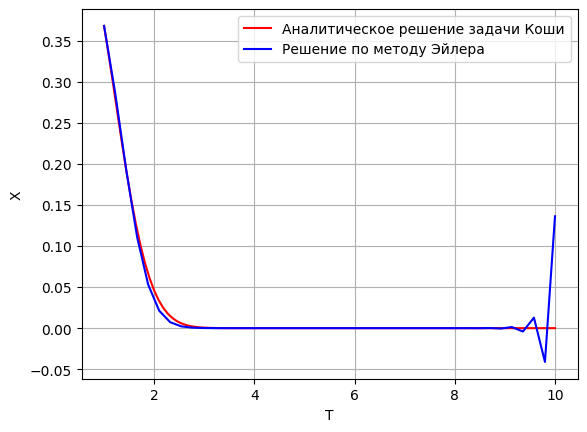

In [9344]:
# Начальные условия
t_segment = [1, 10]
x_0 = [np.exp(-1)]

start_time = time.perf_counter()
dt = 0.22
euler_t, euler_x = Euler_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")

Время работы метода: 0.00019809999503195286


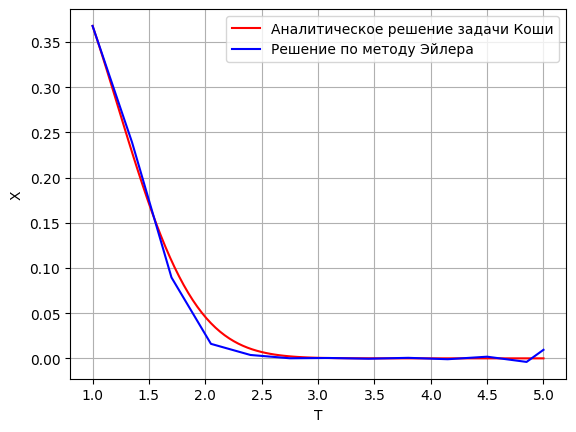

In [9345]:
# Начальные условия
t_segment = [1, 5]
x_0 = [np.exp(-1)]

start_time = time.perf_counter()
dt = 0.35
euler_t, euler_x = Euler_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")

Время работы метода: 0.00021789991296827793


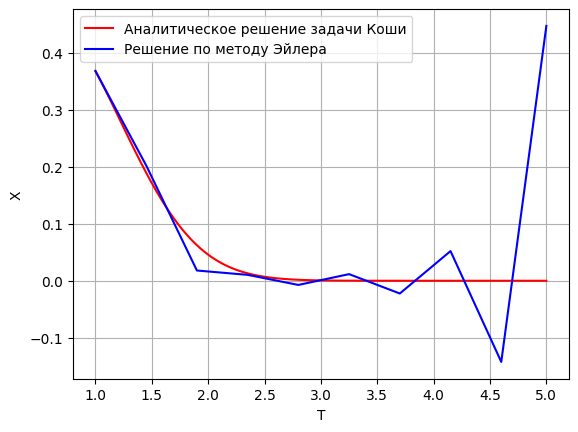

In [9346]:
# Начальные условия
t_segment = [1, 5]
x_0 = [np.exp(-1)]

start_time = time.perf_counter()
dt = 0.45
euler_t, euler_x = Euler_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")

### Сравнение ошибок для метода Рунге-Кутты с разными значениями шага ($\geqslant 3$)

Время работы метода: 0.000667099840939045


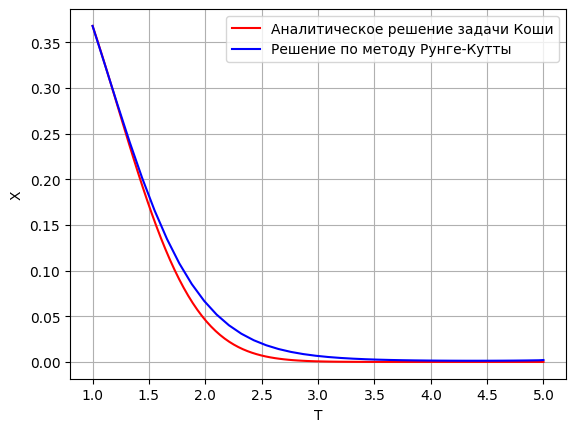

In [9347]:
# Начальные условия
t_segment = [1, 5]
x_0 = [np.exp(-1)]

start_time = time.perf_counter()
dt = 0.11
runge_kutta_t, runge_kutta_x = Runge_Kutta_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(runge_kutta_t, runge_kutta_x, "blue", "Решение по методу Рунге-Кутты")

Время работы метода: 0.0013023000210523605


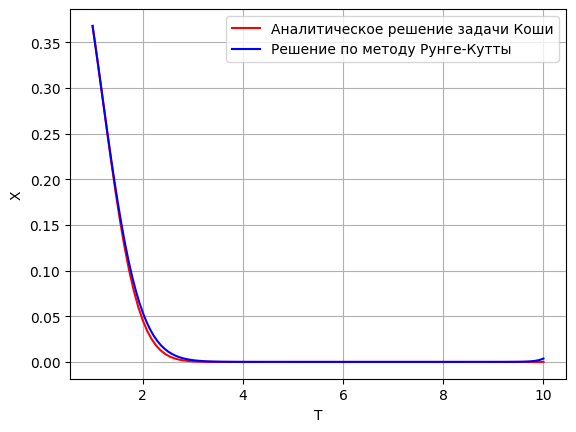

In [9348]:
# Начальные условия
t_segment = [1, 10]
x_0 = [np.exp(-1)]

start_time = time.perf_counter()
dt = 0.072
runge_kutta_t, runge_kutta_x = Runge_Kutta_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(runge_kutta_t, runge_kutta_x, "blue", "Решение по методу Рунге-Кутты")

Время работы метода: 0.0007069997955113649


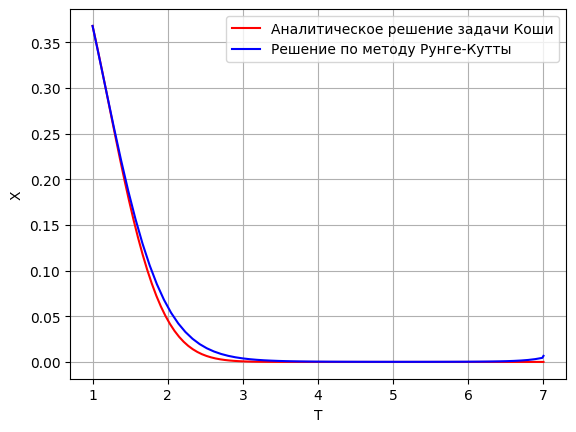

In [9349]:
# Начальные условия
t_segment = [1, 7]
x_0 = [np.exp(-1)]

start_time = time.perf_counter()
dt = 0.095
runge_kutta_t, runge_kutta_x = Runge_Kutta_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(runge_kutta_t, runge_kutta_x, "blue", "Решение по методу Рунге-Кутты")

### Сравнение методов Эйлера и Рунге-Кутты между собой

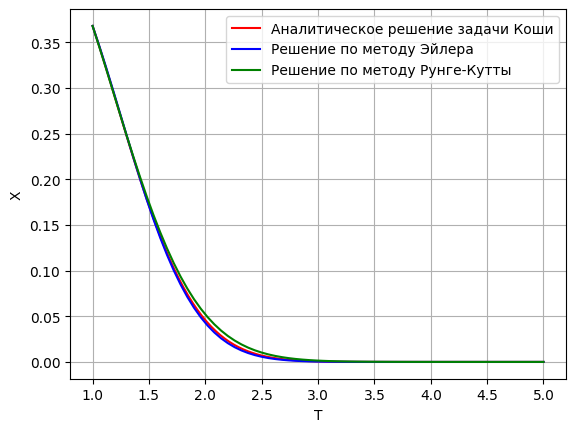

In [9350]:
'''
Разница в ошибках при одинаковых шагах
'''

# Начальные условия
t_segment = [1, 5]
x_0 = [np.exp(-1)]

dt = 0.06
runge_kutta_t, runge_kutta_x = Runge_Kutta_method(f, t_segment, x_0, dt)
euler_t, euler_x = Euler_method(f, t_segment, x_0, dt)


plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")
plot_arr(runge_kutta_t, runge_kutta_x, "green", "Решение по методу Рунге-Кутты")

Значение аналитической функции: 0.04578909722183545
Ошибка метода Эйлера: 0.0013950627916445371
Ошибка метода Рунге-Кутты: 0.001296066190924025


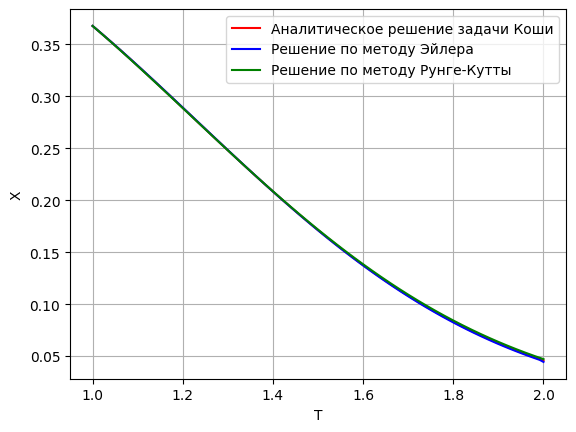

In [9351]:
'''
Разница в шагах при (приблизительно) одинаковой ошибке
'''

# Начальные условия
t_segment = [1, 2]
x_0 = [np.exp(-1)]

euler_dt = 0.0134
runge_kutta_dt = 0.02
runge_kutta_t, runge_kutta_x = Runge_Kutta_method(f, t_segment, x_0, runge_kutta_dt)
euler_t, euler_x = Euler_method(f, t_segment, x_0, euler_dt)

print(f"Значение аналитической функции: {phi(t_segment[-1])}"
      f"\nОшибка метода Эйлера: {abs(phi(t_segment[-1]) - euler_x[-1][0])}"
      f"\nОшибка метода Рунге-Кутты: {abs(phi(t_segment[-1]) - runge_kutta_x[-1][0])}")

plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")
plot_arr(runge_kutta_t, runge_kutta_x, "green", "Решение по методу Рунге-Кутты")


Сделайте вывод относительно связи между размером шага, точностью и временем работы программы.

### Вывод
1. Точность: Метод Рунге-Кутты имеет значительно более высокую точность по сравнению с методом Эйлера при одинаковых значениях шага dt.

2. Сравнение ошибок на одинаковых шагах: При одинаковом шаге dt ошибка метода Эйлера значительно превышает ошибку метода Рунге-Кутты. 
Это указывает на то, что для достижения аналогичной точности метод Эйлера требует значительно более мелкого шага, что, в свою очередь, увеличивает количество шагов и вычислительную нагрузку.

3. Эффективность вычислений: Из-за второго порядка точности метод Рунге-Кутты позволяет использовать больший шаг при той же точности, что и метод Эйлера. Это делает его более эффективным для численного решения задач, так как он требует меньше вычислений для достижения заданной точности.

###### 2. Метод Эйлера справляется, но лишь сильное уменьшение шага дает адекватную точность. Метод Рунге-Кутты справляется хорошо

Придумайте пример дифференциального уравнения с некоторыми начальными условиями, для которого точности метода Эйлера может не хватить, а метод Рунге-Кутты выручает.  

Запустите написанные ранее методы для данной задачи и сравните численное решение с аналитическим (которое, правда, Вам снова придется найти честным способом на бумажке)

Решить методом Бернулли дифференциальное уравнение:
\begin{equation}
\begin{cases}
x^{\prime} + t^2 = 2x + 1 \\
x(0) = \frac{1}{2}.
\end{cases}
\end{equation}

Решение

Пожалуй решение начнем с замены подстановкой $x=u v, x^{\prime}=u^{\prime} v+u v^{\prime}$ Получаем:

$$
uv^{\prime} + vu^{\prime} - 2uv = 1 - t^2
$$

Далее необходимо вынести за скобку общий множитель и в первом и третьем слагаемом левой части дифференциального уравнения. Имеем:

$$
u^{\prime}v + u(v^{\prime} - 2v) = 1 - t^2
$$

Теперь каким-то образом нужно найти неизвестные функции $u$ и $v$. Чтобы их найти придётся составить систему уравнений:

\begin{equation}
\begin{cases}
u(v^{\prime} - 2v) = 0, \\
u^{\prime}v = 1 - t^2.
\end{cases}
\end{equation}

Заметим, что значение первого уравнения мы взяли равным нулю, чтобы из него получить $v$, а затем зная $v$ из второго получить $u$. Приступаем решать её:
$$
v^{\prime} - 2v = 0 \\
v^{\prime} = 2v \\
\frac{d v}{d t} = 2v \\
\int \frac{dv}{v} = \int 2 dt \\
\ln v = 2t \\
v = e^{2t}
$$

Зная теперь чему равно $v$ возьмём и подставим его во второе уравнение системы. Далее найдём $u$:
$$
u^{\prime} \cdot e^{2t} = 1 - t^2 \\
\frac{d u}{d t} = \frac{1 - t^2}{e^{2t}} \\
u = -\int \frac{t^2 - 1}{e^{2t}} dt \\
u = - \int \frac{t^2}{e^{2t}} dt + \int e^{-2t} dt \\
u = - \frac{1}{2e^{2t}} - \int \frac{t^2}{e^{2t}} dt
$$
Решим $\int \frac{t^2}{e^{2t}} dt$. Сделаем замену $q = 2t \rightarrow t = \frac{q}{2}, dt = \frac{1}{2} dq$:
$$
\int \frac{t^2}{e^{2t}} d t = \int \frac{q^2}{8e^q} d q = \frac{1}{8} \int \frac{q^2}{e^q} d q
$$
Проинтегрируем по частям. $u = q^2 \rightarrow du = 2qdq, dv = \frac{1}{e^q}dq \rightarrow v = -\frac{1}{e^q}$. Получим:
$$
\frac{1}{8} \left( -\frac{q^2}{e^q} + \int \frac{2q}{e^q} dq \right)
$$
Проинтегрируем интеграл по частям. $u = q \rightarrow du = dq$, $dv = \frac{1}{e^q}dq \rightarrow v = -\frac{1}{e^q}$. Получим:
$$
\frac{1}{8} \left( -\frac{q^2}{e^q} -\frac{2q}{e^q} + 2\int \frac{1}{e^q} dq \right) = \frac{1}{8} \left( -\frac{q^2}{e^q} -\frac{2q}{e^q} - \frac{2}{e^q} \right)
$$
Обратной подстановкой получим интеграл:
$$
-\frac{2t^2 + 2t + 1}{4e^{2t}} + C
$$
Теперь мы можем получить $u$:
$$
u = - \frac{1}{2e^{2t}} + \frac{2t^2 + 2t + 1}{4e^{2t}} + C = \frac{2t^2 + 2t - 1}{4e^{2t}} + C
$$
Теперь с помощью обратной подстановки мы можем получить $x = uv$:
$$
x = e^{2t} \cdot \left( \frac{2t^2 + 2t - 1}{4e^{2t}} + C \right) = Ce^{2t} + \frac{t^2}{2} + \frac{t}{2} - \frac{1}{4}
$$
Решим задачу Коши:
$$
\frac{1}{2} = Ce^{0} + \frac{0^2}{2} + \frac{0}{2} - \frac{1}{4} \Rightarrow C = \frac{3}{4}
$$

In [9352]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t,x):
    return 2 * x - t ** 2 + 1

In [9353]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    return (3 / 4) * np.exp(2 * t) + (t ** 2 / 2) + (t / 2) - (1 / 4)

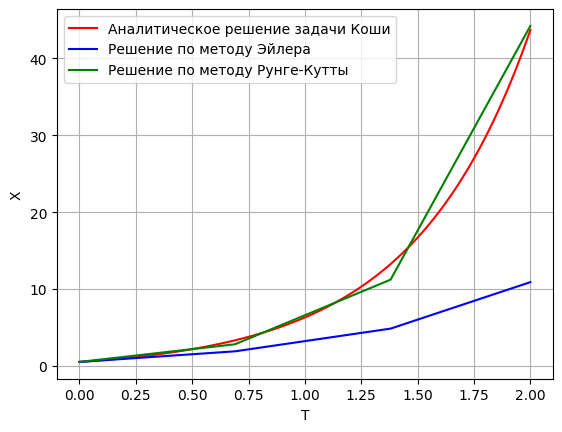

In [9354]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

# Начальные условия
t_segment = [0, 2]
x_0 = [0.5]

dt = 0.69
runge_kutta_t, runge_kutta_x = Runge_Kutta_method(f, t_segment, x_0, dt)
euler_t, euler_x = Euler_method(f, t_segment, x_0, dt)


plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")
plot_arr(runge_kutta_t, runge_kutta_x, "green", "Решение по методу Рунге-Кутты")



Сделайте вывод относительно причин, по которым получается такое поведение методов.

Это уравнение содержит экспоненциальный компонент и квадратичную зависимость по $t$, что усложняет точное вычисление методом Эйлера при больших шагах, так как ошибки будут накапливаться. Однако метод Рунге-Кутты второго порядка, учитывая промежуточное значение (среднее), даёт более точные результаты даже при относительно большом шаге.

###### 3. Оба этих метода не справляются с задачей

Придумайте пример дифференциального уравнения с некоторыми начальными условиями, для которого ни метод Эйлера, ни метод Рунге-Кутты не может получить хорошего результата.  

Запустите написанные ранее методы для данной задачи и сравните численное решение с аналитическим (которое, правда, Вам снова придется найти честным способом на бумажке)

---
> ❗ **Место для Вашего решения дифференциального уравнения**❗
>
> *Вы можете приложить фотографию с решением, используя гугл-диск (как это сделать можно глянуть [здесь](https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive)).*
>
> Вы можете оставить ссылку на файл, лежащий на гугл диске (не забудьте дать доступ на чтение по ссылке)
>
> Вы также можете записать решение, используя Latex, который colab поддерживает.
>
---

❗ **Место для Вашего решения** ❗

In [9355]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t,x):
    ### Место для Вашего решения ###
    pass


In [9356]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    ### Место для Вашего решения ###
    pass


In [9357]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

### Место для Вашего решения ###


'\nПостройте необходимые графики для анализа\n(не забудьте добавить легенду к графикам, чтобы отличать решения)\n'


Сделайте вывод относительно причин неприменимости этих методов.

---
> ❗ **Место для Вашего вывода** ❗
>
> *Мне кажется, что ...*
---

###### 4. Применимость методов для задачи с особым решением

Придумайте пример дифференциального уравнения с некоторыми начальными условиями, для которого существует особое решение.  

Запустите написанные ранее методы для данной задачи и сравните численное решение с аналитическим (которое, правда, Вам снова придется найти честным способом на бумажке)

---
> ❗ **Место для Вашего решения дифференциального уравнения**❗
>
> *Вы можете приложить фотографию с решением, используя гугл-диск (как это сделать можно глянуть [здесь](https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive)).*
>
> Вы можете оставить ссылку на файл, лежащий на гугл диске (не забудьте дать доступ на чтение по ссылке)
>
> Вы также можете записать решение, используя Latex, который colab поддерживает.
>
---

❗ **Место для Вашего решения** ❗

In [9358]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t,x):
    ### Место для Вашего решения ###
    pass


In [9359]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    ### Место для Вашего решения ###
    pass


In [9360]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

### Место для Вашего решения ###


'\nПостройте необходимые графики для анализа\n(не забудьте добавить легенду к графикам, чтобы отличать решения)\n'


Сделайте вывод относительно произошедшего в моделировании и применимости этих методов к задачам с особым решением.

---
> ❗ **Место для Вашего вывода** ❗
>
> *Мне кажется, что ...*
---

#### \* Дополнительное размышление (Дополнительное задание _по желанию_)

Посмотрите, какие методы могут использоваться для исправления выявленных недостатков приведенных выше методов.

- Опишите кратко теоретические выкладки относительно одного из таких методов.
- Попробуйте объяснить, каким образом предложенный метод помогает бороться с различными недостатками.
- Опишите проблемы, которые появляются (или также проявляются) по сравнению с стандартными методами (Эйлера и Рунге-Кутты).
- Приведите пример, в котором методы Эйлера и Рунге-Кутты не решают задачу, а предложенный в этом пункте метод справляется.

## Задание 2. Восстановление цифр по бракованным картинкам.

В этом пункте мы посмотрим на неожи

### Описание задачи

Вам предоставлен кусок тренировочной выборки из базы данных [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). А также бракованные изображения из этого же датасета.

<p>    
    <center>
    <img src="https://drive.google.com/uc?export=view&id=1jgWvIHwXkhQ1iE6ER0Wy_SLxBvCWW1Dd" alt="Проблемы с отображением изображения. Обратитесь к автору" width=500>
    <img src="https://drive.google.com/uc?export=view&id=1AET7slaGnEePLx3qjrxycJSXfHJg55bz" alt="Проблемы с отображением изображения. Обратитесь к автору" width=500>
    <em><br>Пример данных из датасета MNIST<br>Сначала: тренировочные изображения,<br>Потом: бракованные изображения</em>
    </center>
</p>

Необходимо, используя простейшую версию [нейронной сети Хопфилда](https://arxiv.org/abs/2008.02217), восстановить цифры на бракованных изображениях.

<p>    
    <center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/b/b4/Hopfield%27s_net.png" alt>
    <em><br>Пример: схема нейронной сети Хопфилда с тремя нейронами</em>
    </center>
</p>

Переписывая заданную в нейронной сети Хопфилда структуру с $m$ нейронами в виде уравнения в матричном виде, можно получить
$$\boxed{x' = A^T \mathrm{softmax}(\beta Ax) - x}, \tag{1}$$
где $A$ — $\text{матрица}_{(m \times n)}$ весов, $\beta \in \mathbb{R}$, $x$ — $\text{вектор}_{(n, 1)}$ входных нейронов, $\mathrm{softmax}(z)_i = \frac{e^{z_i}}{\sum_{k} e^{z_k}}$ — функция активации.

А значит, задача применения нейронной сети с известной$^*$ матрицей весов сводится к решению дифференциального уравнения (1).

<sub>$^*$ Матрица с весами нетрудно получается на
основе тренировочных данных, о чем мы поговорим чуть дальше.</sub>

Нам дальше понадобится функция $\mathrm{softmax}(x)$. Реализуйте более удобную далее в применении $\mathrm{softmax}(\beta \cdot x)$ в функции `softmax(x, beta)`, рассматривая $x$ как массив `numpy.array`, а $\beta$ — как число.

In [9361]:
'''
Функция softmax(beta*x)
x — numpy.array
beta — число
'''

def softmax(x, beta=1):
    ### Место для Вашего решения ###
    pass


Запишите правую часть уравнения (1), с которым мы дальше будем активно работать, в функцию `dynamics(x, A, beta)`. Используйте в качестве $x$ и $A$ массивы `numpy.array`, а в качестве $\beta$ — число.

In [9362]:
'''
Правая часть уравнения (1)
x — numpy.array
A — numpy.array
beta — число
'''

def dynamics(t, x, A, beta):
    ### Место для Вашего решения ###
    pass


### Интуитивное понимание принципа работы нейронной сети Хопфилда


#### Простой случай на плоскости

Для того, чтобы понять, почему предложенный выше метод работает, необходимо углубиться в дифференциальное уравнение (1).

Как мы помним, для начального анализа мы можем использовать некоторые графические методы. Например, изоклины, или, в более общем случае, --- векторные поля.

Постройте с помощью [`plt.quiver`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) векторное поле для уравнения $x' = A^T \mathrm{softmax} (\beta A x)-x$, положив $A = \begin{bmatrix}1&0\\0&1\\-1&-1\end{bmatrix}$, $\beta=5$.

Добавьте на этот же график точки* $(1,0), (0,1), (-1,-1)$.

_* Заметьте, что это просто точки из матрицы $A$, координаты которых находятся в строках этой матрицы_.

In [9363]:
'''
Векторное поле уравнения x' = A^T softmax(beta * A * x) - x
'''

### Место для Вашего решения ###


"\nВекторное поле уравнения x' = A^T softmax(beta * A * x) - x\n"

Замечаете странное поведение стрелочек? Они как будто смотрят на одну из наших выбранных точек.

Давайте проверим, сохранится ли такое поведение при другой матрице $A$.

Рассмотрите матрицу $A=\begin{bmatrix}2&2\\2&-1\\-3&4\\-4&-3\end{bmatrix}$.

Постройте векторное поле и найдите, какие точки обладают таким же поведением (к ним тянутся стрелочки).


In [9364]:
'''
Векторное поле уравнения x' = A^T softmax(beta * A * x) - x
A = [[2,2],[2,-1],[-3,4],[-4,-3]]
beta = 5
'''

### Место для Вашего решения ###


"\nВекторное поле уравнения x' = A^T softmax(beta * A * x) - x\nA = [[2,2],[2,-1],[-3,4],[-4,-3]]\nbeta = 5\n"

Не кажется ли это очень неплохим свойством? Вспомним, что векторное поле показывает как будто бы «направление скорости» нашей системы. А значит, начиная из какой-нибудь точки на плоскости, мы «скатимся» по стрелочкам в одну из заданных нами в матрице $A$ точек.

Подробнее о таком поведении мы поговорим ближе к концу семестра в курсе, а пока стоит понимать это именно на таком интуитивном уровне.


На самом деле, наша система (1) дает даже больше.

Давайте рассмотрим матрицу $A=\begin{bmatrix}2&3\\-3&2\\2&5\\-2&-3\\3&5\end{bmatrix}$. Видно, что несколько предполагаемых "точек притяжения" сгруппированы в первой четверти плоскости.

Постройте векторное поле для уравнения (1), используя данную матрицу, и посмотрите, как наше уравнение справляется с такими сгруппированными точками.

In [9365]:
'''
Векторное поле уравнения x' = A^T softmax(beta * A * x) - x
A = [[2,3],[-3,2],[2,5], [-2,-3],[3,5]]
beta = 5
'''

### Место для Вашего решения


"\nВекторное поле уравнения x' = A^T softmax(beta * A * x) - x\nA = [[2,3],[-3,2],[2,5], [-2,-3],[3,5]]\nbeta = 5\n"

Замечательно! Оказывается, что среди этих сгруппированных точек выделяется одна, которая «притягивает сильнее».



Возможно, Вам до сих пор не очень понятно, к чему все эти рассуждения и как они помогут нам с обработкой изображения. Давайте переложим рассмотренные выше идеи на датасет `MNIST`.

#### Отношение к изображениям и цифрам

Вспомним, что картинка в компьютере представляется массивом размера `(height, width)`.

Теперь представьте, что мы рассматриваем распрямленную$^*$ картинку, то есть каждый пиксель записан на новой строчке. Получившийся вектор имеет размер `(width*height,1)`.

И этот вектор мы можем подставлять в наше уравнение (1). Решая это уравнение, получим какой-то вектор новой распрямленной картинки, который мы можем обратно привести к исходному размеру `(height, width)`.

<sub>* Заметьте, что мы не теряем информацию о картинке, если помним изначальные размеры, так как в любой момент можем обратно собрать изображение по распрямленному.</sub>

Остается лишь вопрос в матрице $A$. Какую ее брать?

И оказывается, что тут нам помогут наши «точки притяжения». Ведь если мы знаем на каком-то тренировочном наборе, как примерно выглядят цифры, то можем их положить в матрицу $A$. Таким образом, мы получим, что наши тренировочные картинки являются «точками притяжения» для бракованных. А значит любая бракованная, следуя по стрелочкам векторного поля$^*$, придет к одной из тренировочных картинок, тем самым восстановив цифру на изображении.

То есть матрица $A$ будет выглядеть примерно
$$
A =
\begin{bmatrix}
    \text{тренировочная распрямленная картинка 1}\\
    \text{тренировочная распрямленная картинка 2}\\
    \vdots\\
    \text{тренировочная распрямленная картинка k}\\
\end{bmatrix}.
$$

<sub>* Стоит помнить, что теперь мы все манипуляции проворачиваем в пространстве размерности `width*height`. И там уже, конечно, под векторным полем понимается немного другое и изобразить это практически невозможно.</sub>

### Основная часть

#### Загрузка данных

<table>
  <tr>
    <td style="width:40%"><img src=https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.HVapjsP3IhY1D-JsrfGN9gHaEo%26pid%3DApi&f=1&ipt=98ac0d905405b055fade0f342067785a1f2a3e3c9dab7a80c787fcb5627cd771&ipo=images width=200></td>
    <td style="width:50%"><center><p>Выборка из датасета производится случайным образом!<br>
    Если Вы хотите работать с одними и теми же данными,<br>то сохраните файл <code>mnist.npz</code> к себе на компьютер <br>и каждый раз добавляйте его в Colab,<br>пользуясь кодом ниже.<br> Тогда данные будут читаться из него.</center></p></td>
  </tr>
</table>

In [9366]:
# @title Загрузка файла в Colab (Запускайте только если хотите добавить файл)

from google.colab import files
file = files.upload()

ModuleNotFoundError: No module named 'google'

In [ ]:
# @title Загрузка выборки из датасета (запустите ячейку, исходный код скрыт) { vertical-output: true, form-width: "100%", display-mode: "form" }

import os
import torchvision.datasets as datasets
from random import sample

def show_images(images):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,10))
    plt.tight_layout()
    index = 1
    for x in images:
        image = x
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        index += 1

if not os.path.exists('/content/mnist.npz'):
    mnist_trainset = datasets.MNIST(root='/content/MNIST', train=True, download=True)
    train = [np.array(mnist_trainset[k][0]) for k in sample(range(len(mnist_trainset)), 5)]
    test = [np.array(mnist_trainset[k][0]) for k in sample(range(len(mnist_trainset)), 3)]
    np.savez('/content/mnist.npz', train=train, test=test)

data = np.load("/content/mnist.npz")
training_img = data["train"]
training_img = np.asarray(training_img)
corrupted_img = data["test"]
corrupted_img_true = data['test']
for i, item in enumerate(corrupted_img):
    corrupted_img[i][14:, :] = 0

print("Training Images")
show_images(training_img)
plt.show()

print("Corrupted Images")
show_images(corrupted_img)
plt.show()

Теперь у нас есть два набора:
- `training_img` — массив с изображениями, представленными в виде массивов $(28\times 28)$,
- `corrupted_img` — массив с бракованными изображениями, представленными в виде массивов $(28\times 28)$.

#### Обработка данных

Как мы выяснили ранее, для работы с изображениями нам необходимо их распрямить, то есть привести к вектору размера $(784 \times 1)$.

Запишите в переменные `training_img_flatten` и `corrupted_img_flatten` массивы распрямленных изображений соответствующих наборов `training_img` и  `corrupted_img`. Выведите получившиеся размеры массивов, используя [`numpy.shape`](https://numpy.org/doc/stable/reference/generated/numpy.shape.html).

<sub>_Указание:_ воспользуйтесь функцией [`numpy.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)</sub>

In [ ]:
'''
Распрямите изображения и запишите итоговые массивы в переменные training_img_flatten, corrupted_img_flatten.
'''

### Место для Вашего решения ###


#### Обучение сети

Основываясь на наших предположениях из интуитивного понимания принципа работы, заполните матрицу $A$. В этом и заключается обучение нашей сети.

In [ ]:
'''
Задайте матрицу весов A
'''

### Место для Вашего решения ###


$\beta$ зададим равной $10^{-5}$. Вы можете поизменять этот гиперпараметр и написать в выводе, что меняется, или почитать в открытых источниках.

In [ ]:
beta = 1e-5

#### Применение обученной сети = решение дифференциального уравнения

Получается, что применение нашей сети сводится к решению задачи Коши с уравнением (1) и начальным условием, равным бракованной картинке, которую мы хотим восстановить. Понятно, что решать ее в явном виде не имеет смысла (по-крайней мере, потому что это система из 784 уравнений с функцией $\mathrm{softmax}$ внутри). Поэтому будем решать численно.

Воспользуйтесь функцией `Euler_method` из первого задания для решения заданной задачи Коши для каждой бракованной картинки с подставленными матрицей $A$ и скаляром $\beta$.

Получившиеся решения запишите в переменные `solution_i`, где $i$ — порядковый номер бракованной картинки (начинается с нуля).

In [9367]:
'''
Запишите решения задач Коши в переменные solution_i
'''

### Место для Вашего решения ###


'\nЗапишите решения задач Коши в переменные solution_i\n'

Выведите получившиеся восстановленные изображения бок о бок с исходными бракованными. Как Вы думаете, угадал ли компьютер с цифрой? Сделайте вывод почему.

In [9368]:
'''
Вывод изображений: бракованное | восстановленное
'''
### Место для Вашего решения ###



'\nВывод изображений: бракованное | восстановленное\n'

#### Вывод

Сделайте выводы относительно того, насколько удачно сработала нейронная сеть. Порассуждайте, почему так произошло.

---
> ❗ **Место для Вашего вывода** ❗
>
> *Мне кажется, что ...*
---

## Бонус! <sub>но все еще обязательный</sub>

> Я прекрасно знаю, как Вы все любите лабораторные работы с покемонами еще с первого курса.
>
> Поэтому предлагаю свою версию работы про покемонов.

### Описание задачи

Мне кажется, во всем, что связано с покемонами, есть эпизоды, когда по тени необходимо угадать имена покемонов. Именно это и предлагается сделать Вам в бонусном задании.

И, конечно, было бы интересно заставить это делать Вас самих, но лучше попросим об этом волшебную машину с нейронной сетью Хопфилда.

### Основная часть

#### Загрузка данных

<table>
  <tr>
    <td style="width:40%"><img src=https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.HVapjsP3IhY1D-JsrfGN9gHaEo%26pid%3DApi&f=1&ipt=98ac0d905405b055fade0f342067785a1f2a3e3c9dab7a80c787fcb5627cd771&ipo=images width=200></td>
    <td style="width:50%"><center><p>Картинка тени покемона каждый раз выбирается случайным образом!<br>
    Если Вы хотите написать вывод по конкретному покемону,<br>то сохраните картинки тени и результата к себе на компьютер <br>и вставьте картинки в вывод.</center></p></td>
  </tr>
</table>

Это что за покемон?


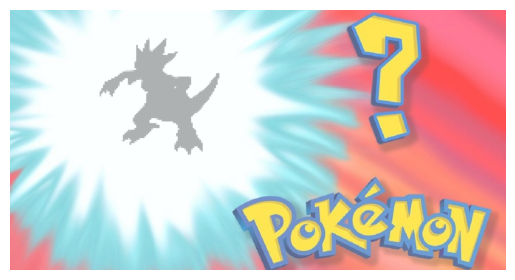

In [9369]:
# @title Загрузка покемонов (запустите ячейку, исходный код скрыт) { vertical-output: true, form-width: "100%", display-mode: "form" }
import matplotlib.image as mpimg
from urllib.request import urlretrieve
from random import choice, sample

background = mpimg.imread(urlretrieve("https://d31xsmoz1lk3y3.cloudfront.net/big/1582671.jpg?v=1558141242", "bg.jpg")[0])

urls = [
    f'https://assets.pokemon.com/assets/cms2/img/pokedex/full/0{i}.png' for i in sample(range(10, 100), 5)
]

training_img = []
shadow_img = []
for url in urls:
    file_name, _ = urlretrieve(url, "test.png")
    img = mpimg.imread(file_name)
    xx = np.linspace(0, img.shape[0] - 1, 80).astype(int)
    yy = np.linspace(0, img.shape[1] - 1, 80).astype(int)
    resized_img = img[xx, :, :][:, yy, :]
    query_img = np.ones(resized_img.shape)
    query_img[:, :, 0] = (resized_img[..., :3].max(axis=2) < 0.01) * 0.0
    query_img[:, :, 1] = (resized_img[..., :3].max(axis=2) < 0.01) * 0.0
    query_img[:, :, 2] = (resized_img[..., :3].max(axis=2) < 0.01) * 0.0
    query_img[:, :, 3] = resized_img[:, :, 3]
    training_img.append(resized_img)
    shadow_img.append(query_img)

training_img = np.asarray(training_img)
shadow_img = choice(shadow_img)
fig = plt.figure(frameon=False)
plt.imshow(shadow_img, origin='lower', extent=[200, 200+4*shadow_img.shape[0],50,50+4*shadow_img.shape[1]])
plt.imshow(background,alpha=0.7)
plt.axis('off')
plt.axis("tight")
plt.axis("image")
print('\033[1m' + 'Это что за покемон?' + '\033[0m')

Теперь в у нас есть:
- `training_img` — массив с цветными изображениями, представленными в виде массивов,
- `shadow_img` — тень какого-то покемона.

#### Обработка данных

Аналогично случаю с изображениями цифр распрямите изображения в массивы.

In [9370]:
'''
Распрямите изображения и запишите итоговые массивы в переменные training_img_flatten, shadow_img_flatten.
'''

### Место для Вашего решения ###


'\nРаспрямите изображения и запишите итоговые массивы в переменные training_img_flatten, shadow_img_flatten.\n'

#### Обучение сети

Обучите сеть, задав матрицу $A$.

In [9371]:
'''
Задайте матрицу весов A
'''

### Место для Вашего решения ###


'\nЗадайте матрицу весов A\n'

In [9372]:
beta = 1e-2

#### Применение обученной сети

Примените обученную сеть, чтобы определить* покемона по его тени.

На этот раз воспользуйтесь написанной в первом задании функцией `Runge_Kutta_method`.

&nbsp;
&nbsp;

_* Может так оказаться, что результат будет неузнаваем. Тогда Вам необходимо будет поизменять отрезок, на котором решается уравнение, или гиперпараметр `beta`. Обычно что-нибудь из этого способно помочь._

In [9373]:
'''
Запишите решения задач Коши в переменные solution
'''

### Место для Вашего решения ###


'\nЗапишите решения задач Коши в переменные solution\n'

Выведите результат бок о бок с тенью.

In [9374]:
'''
Вывод изображений: тень | покемон
'''

### Место для Вашего решения ###


'\nВывод изображений: тень | покемон\n'

#### Вывод

Сделайте выводы относительно того, насколько удачно сработала нейронная сеть. Порассуждайте, почему так произошло.

---
> ❗ **Место для Вашего вывода** ❗
>
> *Мне кажется, что ...*
---

#### Самая обязательная часть

Ну и, естественно, Вам необходимо узнать имя выпавшего покемона и его способности 😀

~~Ведь в этом суть лабораторных по программированию, разве нет?!~~

---
> ❗ **Место для имени и способностей покемона** ❗
>
> *Мне кажется, что это ...*
---